### Load Data

In [1]:
import pandas as pd

# Input path and filename
path = 'D:/Git_Projects/5. Master_thesis/Datasets/'

# Load files into a pandas dataframes
file = path + 'Dataset.xlsx'
#file = path + 'Dataset_outliers.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date")

In [2]:
test_size = 0.2         # Train/Test split
dep_var = 'Orders'      # Dependant variable (TIV or Orders)

### Plot data

In [3]:
import plotly.graph_objs as go
import matplotlib.pylab as plt

title = dep_var + ' 2011–2022'
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines+markers', name= dep_var)))
fig.update_layout(title=go.layout.Title(
 text=title,
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text=dep_var,font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

### Seasonality

In [4]:
import ipywidgets as widgets

#Generate a widget
widget = widgets.IntRangeSlider(value=[2011, 2022], min=2011, max=2022, step=1, description='Time Period:', 
        disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget

#Prepare Data
years = widget.value
years = list(range(years[0],years[1]+1))
df['Year'] = pd.DatetimeIndex(df.index).year
df['Month'] = [d.strftime('%b') for d in df.index]

#Draw Plot
fig = go.Figure()
for i,y in enumerate(years):
    if i<len(years):
        fig.add_trace(go.Scatter(
            x=df[df['Year']==years[i]].Month.tolist(),
            y=df[df['Year']==years[i]].Orders.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(title=go.layout.Title(
        text="Seasonal Trend of Monthly " + dep_var,
        xref="paper",
        x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month",font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text=dep_var,font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"))))
fig.update_yaxes(nticks=10)
   
fig.show()

### Rolling Statistics

A rolling average is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

We will also include the rolling standard deviation to see how much the data varies from the rolling average.

In [5]:
# Determine rolling statistics
# Wwindow size 12 denotes 12 months, giving rolling mean at yearly level
window_size = 12
df["rolling_avg"] = df[dep_var].rolling(window=window_size).mean() 
df["rolling_std"] = df[dep_var].rolling(window=window_size).std()

title = 'Rolling Mean & Standard Deviation'
fig= go.Figure()
fig.add_trace(go.Scatter(dict(x=df.index, y=df[dep_var], mode='lines+markers', name= 'Original')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_avg'], mode='lines', name= 'Rolling Avg')))
fig.add_trace(go.Scatter(dict(x=df.index, y=df['rolling_std'], mode='lines', name= 'Rolling Std')))
fig.update_layout(title=go.layout.Title(
 text=title,
 xref='paper',x=0),
 margin=dict(l=10, r=0, t=50, b=50),
 xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date',font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))),
 yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text=dep_var,font=dict(
 family='Courier New, monospace',
 size=18,
 color='#7f7f7f'))))
fig.show()

df.drop(['rolling_avg', 'rolling_std'], axis=1, inplace=True)

### Split Data

In [6]:
test_size = 0.2         # Train/Test split

# Split data into train and test sets 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=test_size, random_state=42, shuffle=False)

# Print shape
train.shape, test.shape 

((112, 10), (28, 10))

### Time series decomposition 

We separate a time series into its components: trend, seasonality, and residuals. The trend represents the slow-moving changes in a time series. It is responsible for making the series gradually increase or decrease over time. The seasonality component represents the seasonal pattern in the series. The cycles occur repeatedly over a fixed period of time. The residuals represent the behavior that cannot be explained by the trend and seasonality components. They correspond to random errors, also termed white noise.

In [7]:
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import plotly.graph_objs as go

def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates
    return (
        make_subplots(
            rows=4,
            cols=1,
            shared_xaxes=True,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
        .update_xaxes(
            dtick="M6",
            tickformat="%b\n%Y"
        )        
    )

decomposition = seasonal_decompose(df[dep_var], model='additive', period=12)
fig = plot_seasonal_decompose(decomposition, dates=df.index)
fig.show()    

### Augmented Dickey–Fuller Test (Stationarity)

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.

* Null Hypothesis: The data is not stationary.

* Alternative Hypothesis: The data is stationary.

For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:

* p-value <= significance level (0.01, 0.05, 0.10, etc.)

If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

Results of Dickey-Fuller Test:
Test Statistic                   0.078185
p-value                          0.964540
#Lags Used                      12.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


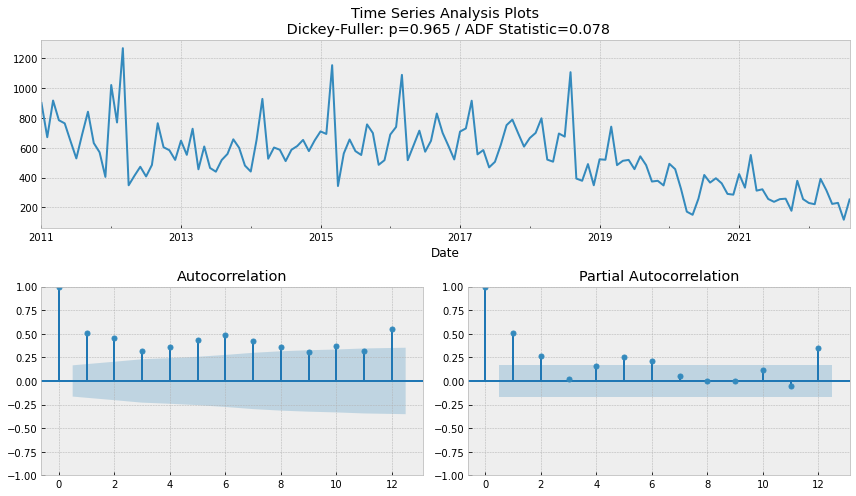

In [8]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Time series analysis plot
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        result = adfuller(y, autolag='AIC',regression='c')
        adf = result[0]
        p_value = result[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.3f} / ADF Statistic={1:.3f}'.format(p_value, adf))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()
        
# Data Stationarity check using Augmented Dickey Fuller(ADF) test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC',regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return dfoutput['p-value']

tsplot(df[dep_var], lags=12)
p_value = adf_test(df[dep_var])     

Results of Dickey-Fuller Test:
Test Statistic                  -5.592580
p-value                          0.000001
#Lags Used                      12.000000
Number of Observations Used    126.000000
Critical Value (1%)             -3.483346
Critical Value (5%)             -2.884766
Critical Value (10%)            -2.579156
dtype: float64


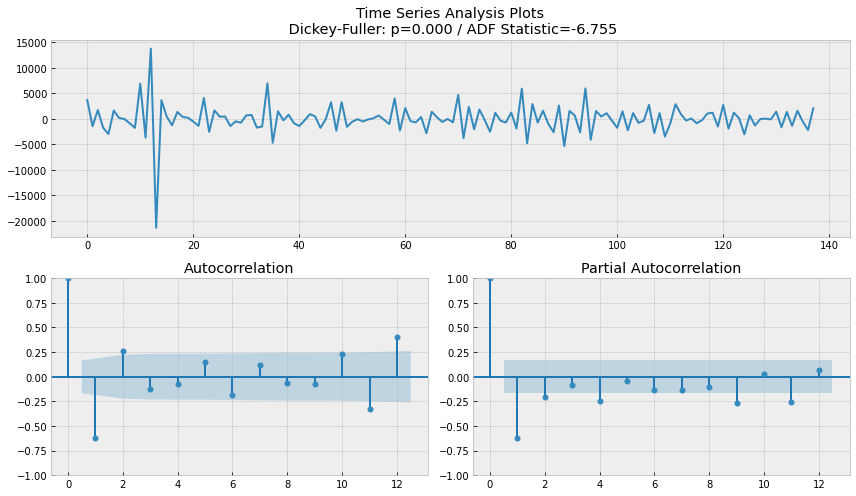

In [9]:
import numpy as np

if p_value > 0.05:
    # Take the first difference to remove to make our series stationary    
    data_diff = np.diff(df.TIV,1)
    tsplot(data_diff[1:], lags=12)
    p_value = adf_test(data_diff)  

In [10]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df[dep_var])

if p_val < 0.05:
    print('Time Series is stationary. p-value is ',  p_val)
else:
    print('Time Series is not stationary. p-value is:',  p_val,'\nDifferencing is needed:', should_diff)

Time Series is not stationary. p-value is: 0.4614291567757055 
Differencing is needed: True


### Scoring function

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf
import math

metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, forecast, actual):
    
    mae = np.mean(np.abs(forecast - actual))                                    # MAE
    mse = mean_squared_error(actual, forecast)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                       # RMSE (Root Mean Squared Error)    
    r2 = r2_score(actual, forecast)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)*100)                # MAPE        
    accuracy = 100 - mape                                                       # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']              

In [12]:
def forecast(ARIMA_model, periods):
    # Forecast
    fitted, confint = ARIMA_model.predict(n_periods=periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df[dep_var], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast")
    plt.show()

In [13]:
def sarimax_forecast(SARIMAX_model, periods, exogenous):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"Orders":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[[exogenous]])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df[dep_var], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of car sales")
    plt.show()

### ARIMA

In [14]:
import pmdarima as pm

#Standard ARIMA Model
ARIMA_model = pm.auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1480.786, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1766.398, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1530.255, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1681.022, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1482.519, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1482.525, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1626.798, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1507.548, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1481.028, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1482.232, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.812 seconds


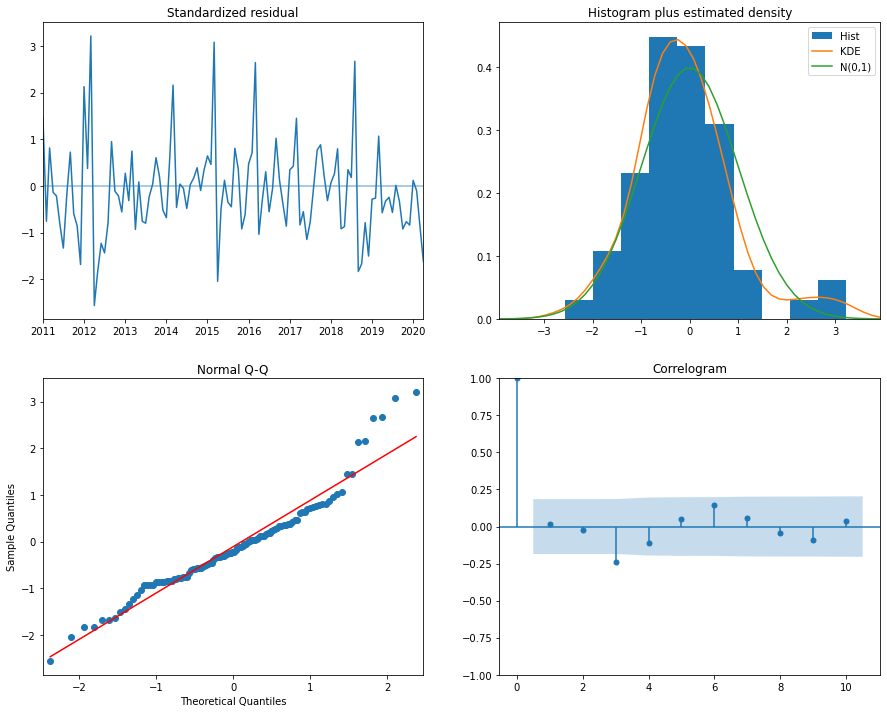

In [15]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [16]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  112
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -737.393
Date:                Mon, 06 Feb 2023   AIC                           1480.786
Time:                        21:44:58   BIC                           1488.942
Sample:                    01-01-2011   HQIC                          1484.095
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.001    721.419      0.000       0.997       1.002
ma.L1         -0.8634      0.054    -16.122      0.000      -0.968      -0.758
sigma2       2.96e+04   3152.195      9.389      0.000    2.34e+04    3.58e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                27.29
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.83
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



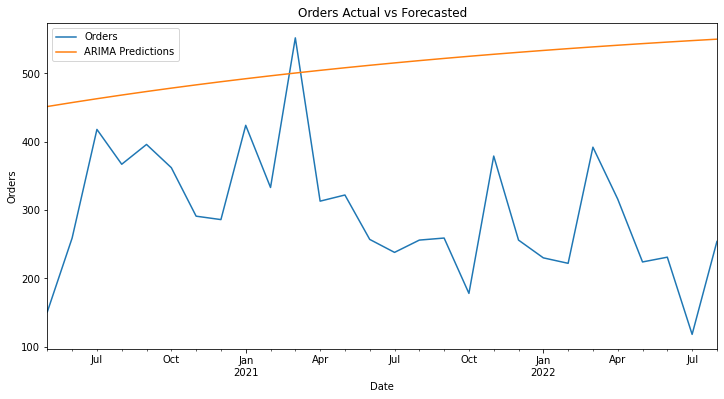

In [17]:
import statsmodels.api as sm

# Build model
model = sm.tsa.arima.ARIMA(train[dep_var],order=(1,0,1))

# Fit model
result = model.fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [18]:
forecast_accuracy('ARIMA', predictions, test[dep_var])

In [19]:
metrics

,ARIMA
Mean Absolute Error,216.884043
Mean Squared Error,56416.152998
Root Mean Squared Error,237.520848
R^2,-5.761474
Mean Absolute Percentage Error,92.836228
Accuracy,7.163772


### SARIMA

In [20]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1291.867, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1322.288, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1302.052, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1296.565, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1323.703, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1318.382, Time=0.19 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1294.019, Time=1.29 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1293.889, Time=2.24 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1301.194, Time=0.81 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1293.914, Time=0.39 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1296.663, Time=1.13 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1292.174, Time=1.19 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1304.578, Time=0.30 sec
 ARIMA(0,0,2)(0,1,1)[12]

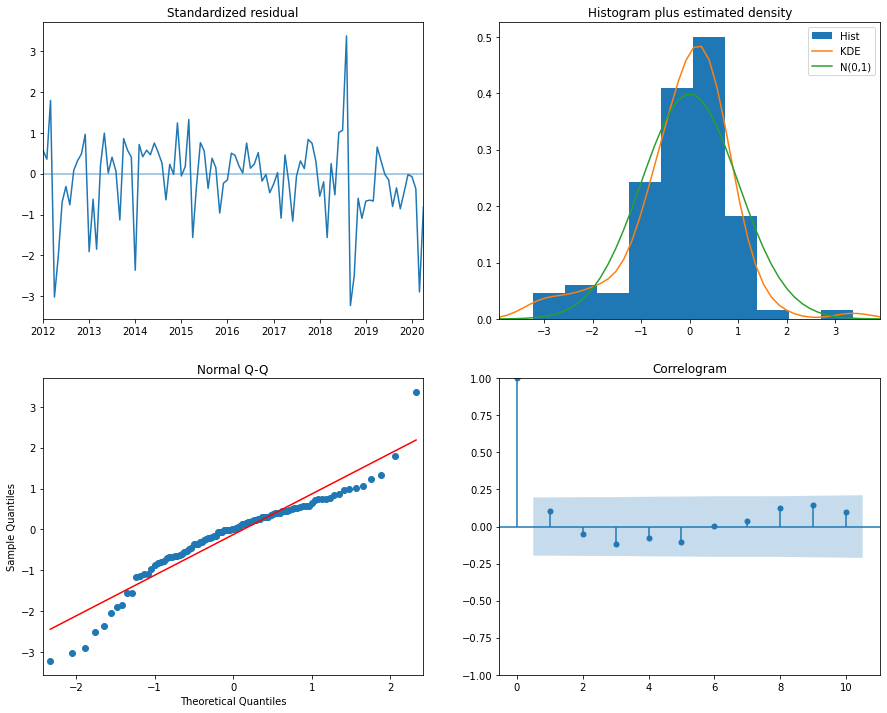

In [21]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [22]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -641.901
Date:                            Mon, 06 Feb 2023   AIC                           1291.801
Time:                                    21:50:22   BIC                           1302.222
Sample:                                01-01-2011   HQIC                          1296.018
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9807      0.056     17.512      0.000       0.871       1.091
ma.L1         -0.8084      0.089     -9.060      0.000      -0.983      -0.633
ma.S.L12      -0.7090      0.146     -4.869      0.000      -0.994      -0.424
sigma2       2.03e+04   2149.662      9.443      0.000    1.61e+04    2.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                26.86
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.61
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



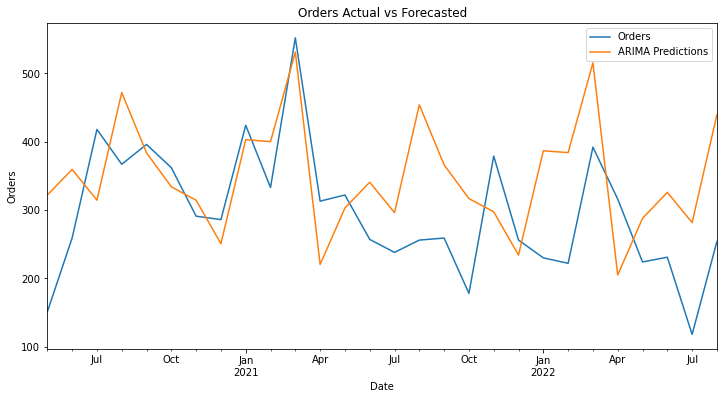

In [23]:
import statsmodels.api as sm

# Build model
model = sm.tsa.arima.ARIMA(train[dep_var],order=(1,0,1),seasonal_order=(0,1,1,12))
# Fit model
result = model.fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [24]:
forecast_accuracy('SARIMA', predictions, test[dep_var])

In [25]:
metrics

,ARIMA,SARIMA
Mean Absolute Error,216.884043,91.063010
Mean Squared Error,56416.152998,11366.658228
Root Mean Squared Error,237.520848,106.614531
R^2,-5.761474,-0.362294
Mean Absolute Percentage Error,92.836228,38.349294
Accuracy,7.163772,61.650706


### SARIMAX

In [26]:
# SARIMAX = SARIMA with exogenous variable
exo_var = 'TIV'
SARIMAX_model = pm.auto_arima(train[dep_var], exogenous=train[exo_var],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1291.867, Time=0.74 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1322.288, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1302.052, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1296.565, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1323.703, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1318.382, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1294.019, Time=1.25 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1293.889, Time=2.30 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1301.194, Time=0.78 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1293.914, Time=0.38 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1296.663, Time=1.16 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1292.174, Time=1.24 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1304.578, Time=0.30 sec
 ARIMA(0,0,2)(0,1,1)[12]

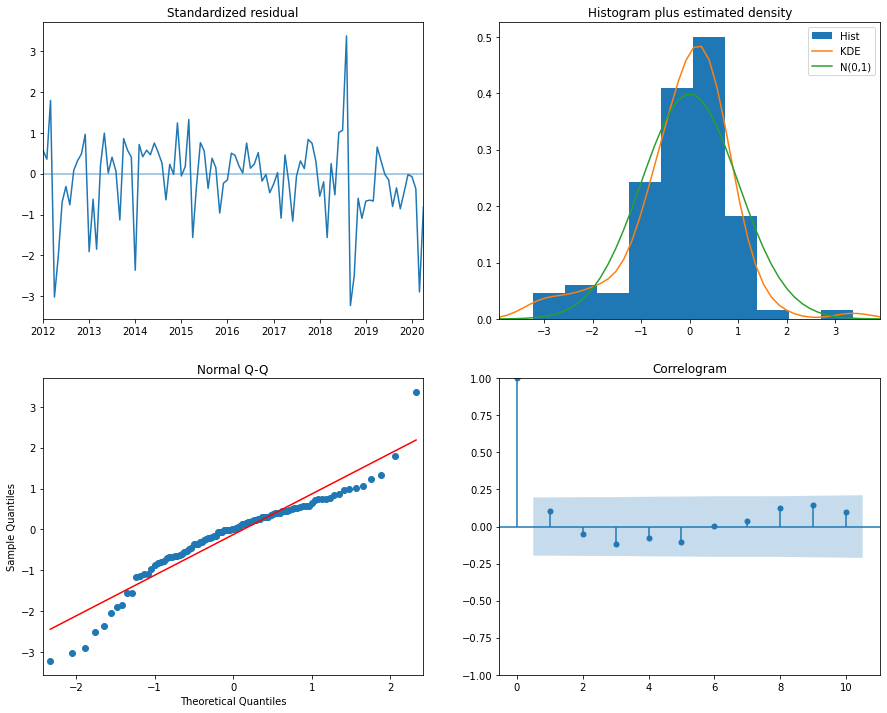

In [27]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [28]:
SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -641.901
Date:                            Mon, 06 Feb 2023   AIC                           1291.801
Time:                                    21:51:28   BIC                           1302.222
Sample:                                01-01-2011   HQIC                          1296.018
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9807      0.056     17.512      0.000       0.871       1.091
ma.L1         -0.8084      0.089     -9.060      0.000      -0.983      -0.633
ma.S.L12      -0.7090      0.146     -4.869      0.000      -0.994      -0.424
sigma2       2.03e+04   2149.662      9.443      0.000    1.61e+04    2.45e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                26.86
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.61
Prob(H) (two-sided):                  0.50   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



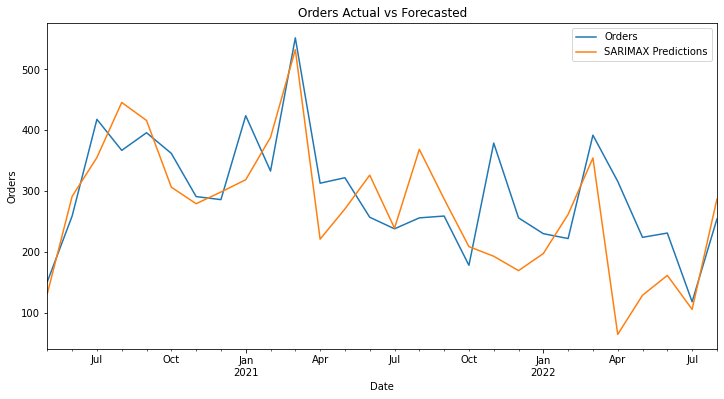

In [29]:
# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(1,0,1),seasonal_order=(0,1,1,12),exog = train[exo_var])

# Fit model
result = model.fit()

# Predict
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels').rename('SARIMAX Predictions')

# Plot predictions
ax = test[dep_var].plot(legend=True,figsize=(12,6),title=dep_var + ' Actual vs Forecasted')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(ylabel=dep_var);

In [30]:
forecast_accuracy('SARIMAX with ' + exo_var , predictions, test[dep_var])

In [31]:
metrics

,ARIMA,SARIMA,SARIMAX with TIV
Mean Absolute Error,216.884043,91.063010,60.824494
Mean Squared Error,56416.152998,11366.658228,6603.139763
Root Mean Squared Error,237.520848,106.614531,81.259706
R^2,-5.761474,-0.362294,0.208614
Mean Absolute Percentage Error,92.836228,38.349294,20.750180
Accuracy,7.163772,61.650706,79.249820
